<a href="https://colab.research.google.com/github/greglcr/Diffusion-ML_for_Physics/blob/main/gaussiennes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset

#En local ça sert à rien car j'ai pas de GPU mais si je passe sur collab ça sera utile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


L'idée ça va être de créer des fonctions différentes qui vont générer des dataset en 2D pour l'instant, comme ça c'est vraiment simple à visualiser. L'idée ça va être de donner un code général qui marche un des vecteurs généraux, comme ça sera facilement généralisable plus tard

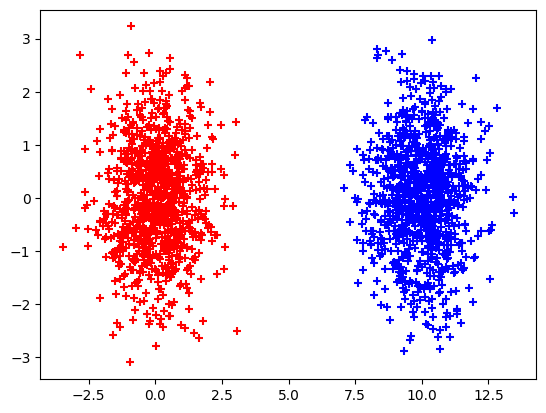

In [ ]:
from math import sqrt

def genere_gaussienne(center=(0, 0), sigma=1, nbPoint=1000, dimension=2):
    return torch.randn((nbPoint, dimension)) * sigma + center
def genere_spirale(center, radius):
    #To complete
    return

def bluring(trainSet, nbBluring=100):
    nbPoint = trainSet.shape[1]
    dimension = trainSet.shape[2]
    betas = torch.arange(0, nbBluring + 1) / (5 * nbBluring)
    for t in range(1, nbBluring + 1):
        beta = betas[t]
        addBluring = sqrt(1 - beta) * trainSet[t - 1 : t, :, :] + torch.randn(1, nbPoint, dimension) * sqrt(beta)
        trainSet = torch.concat((trainSet, addBluring))
    return trainSet

def gen_gaussian_blured(center=0, sigma=1, nbPoint=1000, dimension=2, nbBluring=100):
    trainSet = torch.randn((1, nbPoint, dimension)) * sigma + center
    return bluring(trainSet, nbBluring)

def visualize_data(myPoint):
    plt.scatter(myPoint[:, 0], myPoint[:, 1], marker = '+')

def visualize_gausian_blured(trainSet, times):
    #Pour le moment, seulement le premier et le dernier, peut-être que je ferais des meilleures visualisation plus tard
    plt.scatter(trainSet[times[0], :, 0], trainSet[times[0], :, 1], marker = '+', color = 'blue')
    plt.scatter(trainSet[times[1], :, 0], trainSet[times[1], :, 1], marker = '+', color = 'red')

visualize_gausian_blured(gen_gaussian_blured(center=torch.tensor([10, 0])), [0, 100])
#Il va falloir faire des test mais il semblerait que la valeur de 50 pour le bluring est beaucoup trop élevée, 20 pourrait suffire

In [ ]:
#Maintenant on va enfin générer le trainset
def gen_train_set(points):

    features = []
    labels = []

    for t in range(1, points.shape[0]):
        for i in range(points.shape[1]):
            pointFeature = torch.concat((points[t][i], torch.tensor([t]))).tolist()
            features.append(pointFeature)
            pointLabel = (points[t][i] - points[t - 1][i]).tolist()
            labels.append(pointLabel)

    return (torch.tensor(features), torch.tensor(labels))

Il faut vraiment que je reflechisse à quoi va ressembler mes données. La fonction que je dois apprendre doit prendre prend comme paramètre x et la valeur au temps t, elle doit retourner la différence entre ce point et sa valeur au temps x_t - x_{t - 1}. Il faut donc que je construise ce data set à partir de ces données.

In [ ]:
#CNN pour apprendre nos paramètres de diffusion. Le CNN prend en argument les données d'entrée (et donc de sortie), la largeur et la profondeur. Comme ça, on pourra apprendre
#avec plein de modèle différents
#On choisit une fonction d'activatino ReLU
class MLP_for_diffusion(nn.Module):
    def __init__(self, dataSize, width, depth):
        super().__init__()
        self.width = width
        self.depth = depth
        self.dataSize = dataSize
        self.architecture = nn.ModuleList()
        self.architecture.append(nn.Linear(dataSize + 1, width))
        for i in range(depth - 1):
            self.architecture.append(nn.Linear(width, width))
        self.architecture.append(nn.Linear(width, dataSize))
        self.activation = nn.ReLU()

    def forward(self, x):
        out = x
        for i in range(self.depth + 1):
            out = self.architecture[i](out)
            if i < self.depth:
                out = self.activation(out)
        return out

In [ ]:
def train(model, epoch, trainloader):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.train()
    model.to(device)

    loss_function = nn.MSELoss()

    for _ in range(epoch):
        for (inputs, targets) in trainloader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            out = model(inputs)

            loss = loss_function(out, targets)
            loss.backward()
            optimizer.step()

#Pour tester notre modèle, on veut juste partir de plein de point différent. Mais le truc c'est qu'il va falloir formater les données pour avoir le temps dedans
def test(model, nbApply=100, nbPoint=1000, dimension=2):
    startingPoint = torch.randn((nbPoint, dimension + 1))
    startingPoint[:, dimension] = nbApply
    startingPoint = startingPoint.to(device)
    for t in range(nbApply, 0, -1):
        startingPoint[:, 0:dimension] -= model(startingPoint[:, :])
        startingPoint[:, dimension] = t
    return startingPoint[:, 0:dimension]

In [ ]:
features, labels = gen_train_set(gen_gaussian_blured(center = torch.tensor([10, 10])))
dataset = TensorDataset(features, labels)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=50, drop_last=True)

In [ ]:
model = MLP_for_diffusion(2, 100, 4)
train(model, 30, train_loader)

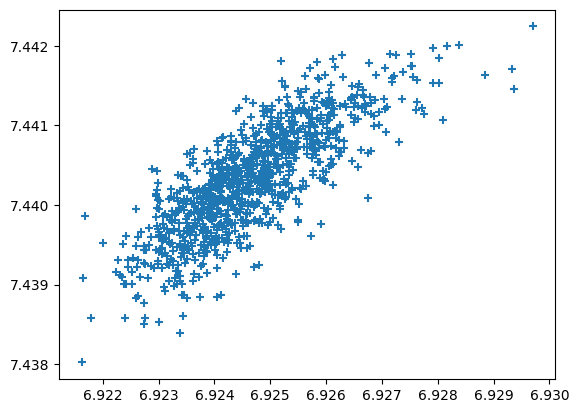

In [ ]:
visualize_data(test(model).cpu().detach().numpy())

In [ ]:
model.to('cpu')
a = torch.tensor([0., 0., 20.])
for t in range(20, 0, -1):
    a[0:2] -= model(a)
    a[2] = t
    print(a)


tensor([ 0.1422,  0.0832, 20.0000], grad_fn=<CopySlices>)
tensor([ 0.2820,  0.1643, 19.0000], grad_fn=<CopySlices>)
tensor([ 0.4205,  0.2451, 18.0000], grad_fn=<CopySlices>)
tensor([ 0.5581,  0.3259, 17.0000], grad_fn=<CopySlices>)
tensor([ 0.6933,  0.4059, 16.0000], grad_fn=<CopySlices>)
tensor([ 0.8259,  0.4857, 15.0000], grad_fn=<CopySlices>)
tensor([ 0.9563,  0.5672, 14.0000], grad_fn=<CopySlices>)
tensor([ 1.0848,  0.6504, 13.0000], grad_fn=<CopySlices>)
tensor([ 1.2119,  0.7355, 12.0000], grad_fn=<CopySlices>)
tensor([ 1.3375,  0.8222, 11.0000], grad_fn=<CopySlices>)
tensor([ 1.4633,  0.9137, 10.0000], grad_fn=<CopySlices>)
tensor([1.5898, 1.0101, 9.0000], grad_fn=<CopySlices>)
tensor([1.7143, 1.1074, 8.0000], grad_fn=<CopySlices>)
tensor([1.8385, 1.2072, 7.0000], grad_fn=<CopySlices>)
tensor([1.9693, 1.3149, 6.0000], grad_fn=<CopySlices>)
tensor([2.1078, 1.4327, 5.0000], grad_fn=<CopySlices>)
tensor([2.2405, 1.5469, 4.0000], grad_fn=<CopySlices>)
tensor([2.3732, 1.6673, 3.0000],